In [1]:
import numpy as np
import qilisdk
import qutip as qt
import matplotlib.pyplot as plt
import sys

sys.path.append('../src')

import hamiltonian
import dynamics
import plots
import estimator
import VQE

from qilisdk.backends import QutipBackend
from qilisdk.digital import Circuit, M, U1, CNOT, U2, U3, CZ, RX, RZ, H
from qilisdk.functionals.sampling import Sampling, SamplingResult
from qilisdk.functionals.time_evolution import TimeEvolution
from scipy.optimize import minimize

from qilisdk.analog import Schedule, X, Z, Y
from qilisdk.core import ket, tensor_prod
from qilisdk.backends import QutipBackend, CudaBackend
from qilisdk.functionals import TimeEvolution

## Define target Hamiltonian and perform time evolution classically

In [13]:
nqubits = 2
min_w = -1.
max_w = 1.

psi_0 = dynamics.initialize_down_state(nqubits)

#define target weights and create H

true_weights = [0.5, 0.8]
#true_weights = [0.5, 0.25, -0.8, 0.1, 0.32]
true_weights = [-0.66275718, -0.90763743,  0.14737293,  0.6965676,  -0.41580799]
H_true = hamiltonian.create_hamiltonian_from_weights(nqubits, true_weights, backend='qutip')

#alternatively generate random H
# H_true, true_weights = hamiltonian.create_random_hamiltonian(nqubits, min_w, max_w, backend='qutip')

print(H_true.H, "\n")

print("Weights:", true_weights)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.42813254 -0.90763743 -0.66275718  0.        ]
 [-0.90763743 -0.13338668  0.         -0.66275718]
 [-0.66275718  0.          0.96500266 -0.90763743]
 [ 0.         -0.66275718 -0.90763743 -1.25974852]] 

Weights: [-0.66275718, -0.90763743, 0.14737293, 0.6965676, -0.41580799]


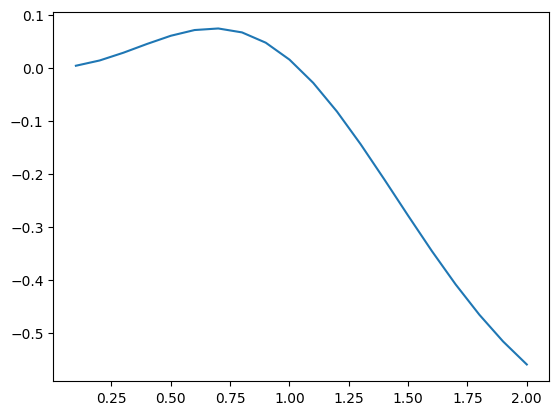

In [20]:
ti = 0
times = np.linspace(0.1, 2, 20)
nsteps = 1000
nshots = 500

target_states = []
z_list_1, z_list_2, x_list_1, x_list_2 = [], [], [], []

for tf in times:
    sim = dynamics.time_evolution(H_true, psi_0, ti, tf, nsteps)
    observables = dynamics.calculate_expectation_values(sim, H_true)

    z_list_1.append(float(observables['Sz'][-1][0]))
    x_list_1.append(float(observables['Sx'][-1][0]))
    z_list_2.append(float(observables['Sz'][-1][1]))
    x_list_2.append(float(observables['Sx'][-1][1]))

    target_state = sim.states[-1]
    target_states.append(target_state)

plt.plot(times, x_list_1)

## Apply VQE

This time, we simulate a Hamiltonian, sample from it and then calculate nll against target Hamiltonian

In [15]:
nshots = 2000

H_initial, initial_weights = hamiltonian.create_random_hamiltonian(nqubits, min_w, max_w, backend='qutip')


res = minimize(
    fun=lambda p: VQE.inverse_nll_cost(p, nqubits, psi_0, ti, times, nsteps, nshots, target_states),
    x0=initial_weights,
    method='L-BFGS-B',
    jac=lambda p: estimator.parameter_shift_grad(
        lambda x: VQE.inverse_nll_cost(x, nqubits, psi_0, ti, times, nsteps, nshots, target_states),
        p
    ),
    options={
        'maxiter': 2000,           # Increase iterations
        'ftol': 1e-10,            # Function tolerance
        'gtol': 1e-8,             # Gradient tolerance  
        'maxfun': 10000,          # Max function evaluations
        'disp': True              # Print convergence messages
    }
)

# res = minimize(lambda p: VQE.inverse_nll_cost(p, nqubits, psi_0, ti, times, nsteps, nshots, target_states),
#                initial_weights, method='COBYLA',
#                options={'maxiter': 200})

print("Optimization finished, success:", res.success, ", loss function:", res.fun)
print("best parameters:", res.x)
print(true_weights)

/var/folders/wh/28dwfv8x0qzfwl1_0pyzvs6h0000gp/T/ipykernel_45239/108891132.py:6: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(


2.943091849501908
2.9390531419945907
2.9450967451087613
2.9563897340143646
2.9410085410418474
2.945866332065722
2.9561257586754355
2.9484544433429756
2.9403488916913627
2.9538553253219337
2.971325343610331
2.9283859389804268
3.8253881224922153
3.81533185452834
3.8591249533794185
3.7498026909656077
3.798875845449873
3.8135193842444326
3.7609949077918707
3.8679312022982693
3.7777941848362087
3.838963193645176
3.770602963156125
3.865538148722434
2.930950366164695
2.923478712557845
2.9457809380912336
2.917090838760278
2.91289184566123
2.928350522082997
2.9176650076576345
2.93994099658999
2.917594359387256
2.9222543196350323
2.9234749746812922
2.9292146269401247
2.9049473933243863
2.9040375097427726
2.9058994631415325
2.914320199213312
2.884089364228655
2.906915950362211
2.9028425227348738
2.913043450048074
2.8915229563722575
2.9005987430606828
2.9211520332360172
2.902734053211414
2.8404303454134303
2.8437948085088953
2.798366387766031
2.919893811140181
2.8151102978145954
2.8563869261609445

In [18]:
H_final = hamiltonian.create_hamiltonian_from_weights(nqubits, res.x, backend='qutip')

z_list_3, x_list_3, z_list_4, x_list_4 = [] , [], [] , []

for tf in times:
    sim = dynamics.time_evolution(H_final, psi_0, ti, tf, nsteps)
    observables = dynamics.calculate_expectation_values(sim, H_final)

    z_list_3.append(float(observables['Sz'][-1][0]))
    x_list_3.append(float(observables['Sx'][-1][0]))
    z_list_4.append(float(observables['Sz'][-1][1]))
    x_list_4.append(float(observables['Sx'][-1][1]))

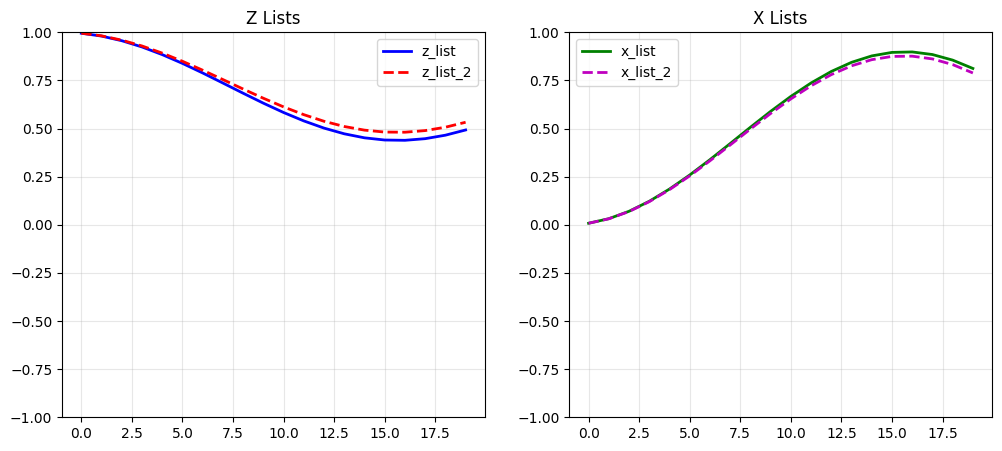

In [12]:
def plot_expectations(z_list, x_list, z_list_2, x_list_2):
    # Create side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Left plot: z lists
    ax1.plot(z_list, 'b-', label='z_list', linewidth=2)
    ax1.plot(z_list_2, 'r--', label='z_list_2', linewidth=2)
    ax1.set_title('Z Lists')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-1,1)
    # Right plot: x lists  
    ax2.plot(x_list, 'g-', label='x_list', linewidth=2)
    ax2.plot(x_list_2, 'm--', label='x_list_2', linewidth=2)
    ax2.set_title('X Lists')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(-1,1)


plot_expectations(z_list_1, x_list_1, z_list_3, x_list_3)

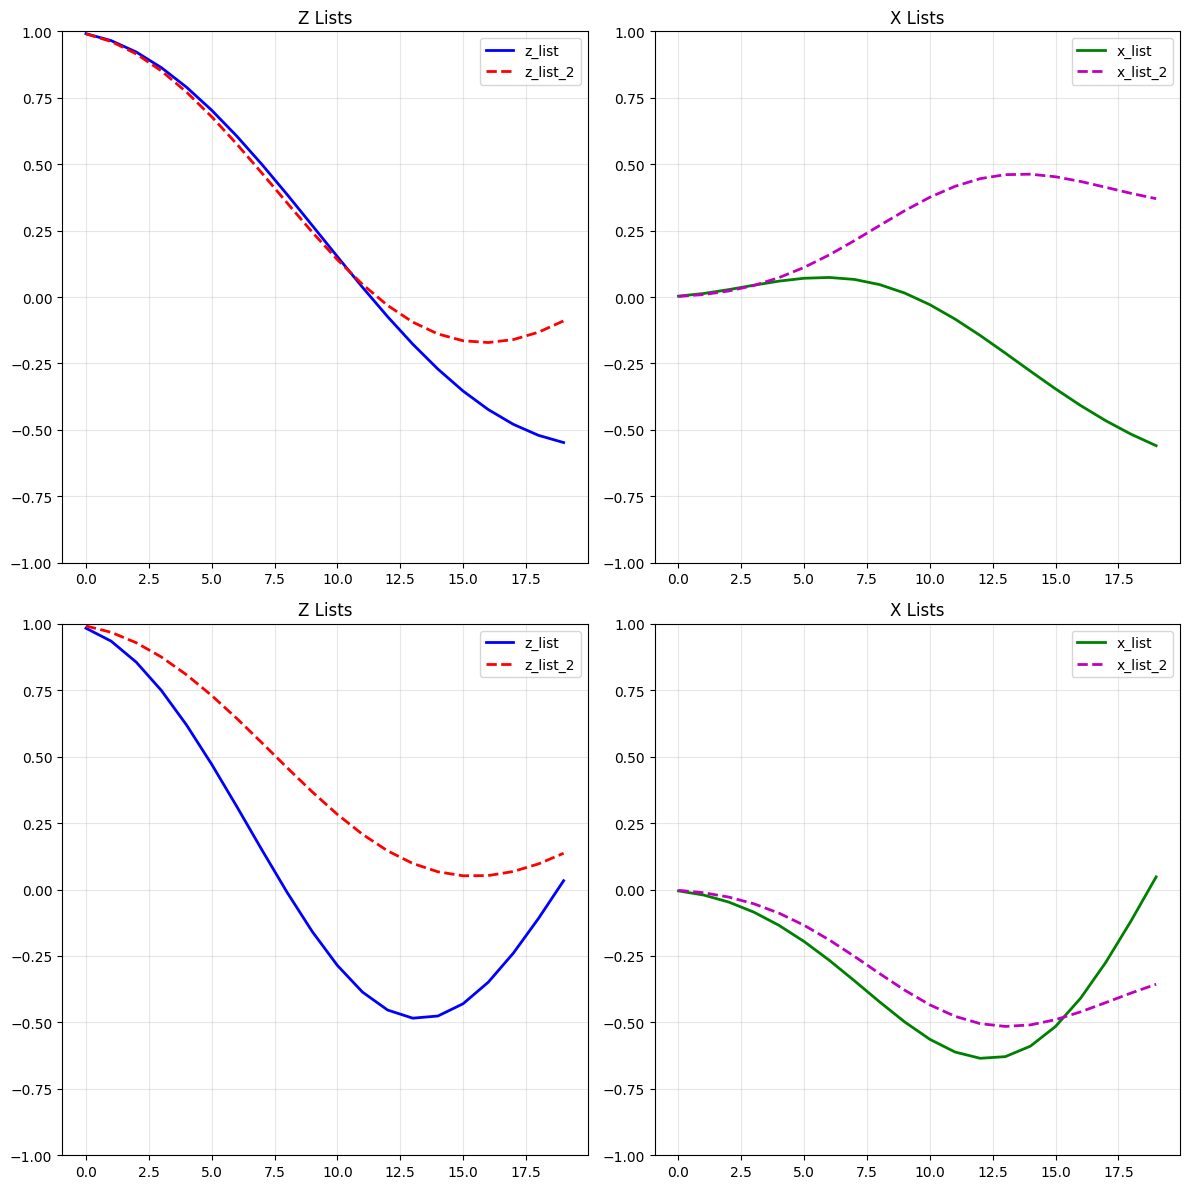

In [21]:
def plot_expectations(z_list, x_list, z_list_2, x_list_2, z_list_3, x_list_3, z_list_4, x_list_4):
    # Create side-by-side subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

    # Left plot: z lists
    ax1.plot(z_list, 'b-', label='z_list', linewidth=2)
    ax1.plot(z_list_3, 'r--', label='z_list_2', linewidth=2)
    ax1.set_title('Z Lists')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-1,1)
    # Right plot: x lists  
    ax2.plot(x_list, 'g-', label='x_list', linewidth=2)
    ax2.plot(x_list_3, 'm--', label='x_list_2', linewidth=2)
    ax2.set_title('X Lists')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(-1,1)

    # Left plot: z lists
    ax3.plot(z_list_2, 'b-', label='z_list', linewidth=2)
    ax3.plot(z_list_4, 'r--', label='z_list_2', linewidth=2)
    ax3.set_title('Z Lists')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(-1,1)
    # Right plot: x lists  
    ax4.plot(x_list_2, 'g-', label='x_list', linewidth=2)
    ax4.plot(x_list_4, 'm--', label='x_list_2', linewidth=2)
    ax4.set_title('X Lists')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(-1,1)
    plt.tight_layout()
    plt.show()


plot_expectations(z_list_1, x_list_1, z_list_2, x_list_2, z_list_3, x_list_3, z_list_4, x_list_4)